In [45]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import os
import math
import numpy as np
import tkinter as tk
from PIL import Image
from PIL import ImageTk
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

print(tf.__version__)

2.9.1


In [104]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def resize_image(imagename, width=256, height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  pil_image = Image.open(imagename)
  pil_image = ImageOps.fit(pil_image, (width, height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)

  if display:
    display_image(pil_image)

  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

    return [left, right, top, bottom]

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  validResults = []
  points = []

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      validResults.append([class_names[i].decode("ascii"), scores[i]])
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      edges = draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
      points.append(edges)
  return image, validResults, points

In [3]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [105]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels = 3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key, value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))

  image_with_boxes, results, dims = draw_boxes(
      img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
  
  #display_image(image_with_boxes)

  im = Image.fromarray(image_with_boxes)

  return results, im, dims

In [19]:
def detect_img(img_url):
  image_path = resize_image(img_url, 640, 480)
  detected, im, dims = run_detector(detector, image_path)
  print("done")
  return detected, im, dims

In [10]:
def load_image_into_numpy_array(path):

      image = Image.open(path)
      #image = Image.open(BytesIO(im_data))
      (im_width, im_height) = image.size

      return np.array(image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)

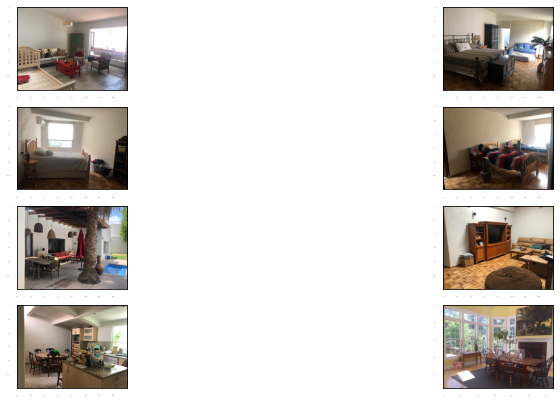

In [28]:
train_image_dir = './house_im/'
train_images_np = []
num_images = 8
for i in range(1, num_images + 1):
  image_path = os.path.join(train_image_dir, 'test' + str(i) + '.jpeg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(4, 2, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [91]:
relevant_categories = {'Furniture': 0.00061, 
                        'Table': 0.0043, 
                        'Coffee table': 0.0046, 
                        'Kitchen table': 0.0031, 
                        'Couch': 0.0021, 
                        'Studio couch': 0.0019, 
                        'Chair': 0.0026, 
                        'Stairs': 0.0169, 
                        'Shelf': 0.00061,
                        'Desk': 0.0039,
                        'Houseplant': 0.00021,
                        'Window': 0.0018,
                        'Door': 0.0018,
                        'Bed': 0.00579,
                        'Toilet': 0.0016,
                        'Sink': 0.0011,
                        'Bathroom cabinet': 0.00061,
                        'Bathroom accessory': 0.00092
                        }

In [111]:
def calculate_risk(results, dims):
    rel_res = []
    rel_dims = []

    risk = 0

    # reject irrelevant categories and calculate baseline risk

    for i in range(len(results)):
        if results[i][0] in relevant_categories:
            rel_res.append(results[i])
            rel_dims.append(dims[i])

            risk = risk + relevant_categories[results[i][0]]

    #print("baseline risk: " + str(risk))

    # extract centroid of each bounding box to compare closeness

    centroids = []
    # Dim format = left, right, top, bottom
    for i in range(len(rel_dims)):
        # top left corner = dims[2], dims[0]
        # bottom right corner = dim[3], dims[1]
        x1 = rel_dims[i][2]
        y1 = rel_dims[i][0]
        x2 = rel_dims[i][3]
        y2 = rel_dims[i][1]
        centroids.append([(x1+x2)/2, (y1+y2)/2])

    # contextual risk based on closeness
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            #print("comparing box " + str(i) + " with box " + str(j) + " : ")
            if math.dist(centroids[i], centroids[j]) < 150:
                #print("object " + str(rel_res[i]) + " and object " + str(rel_res[j]) + " are in close proximity")
                #print("distance: " + str(math.dist(centroids[i], centroids[j])))
                normalised_dist = math.dist(centroids[i], centroids[j]) / 150
                temp_risk = relevant_categories[rel_res[i][0]] * normalised_dist
                risk = risk + temp_risk

    #print("context-based risk: " + str(risk))
    return risk

C:\Users\lucot\AppData\Local\Temp/ipykernel_19604/2430999060.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (width, height), Image.ANTIALIAS)


Found 100 objects.
done


C:\Users\lucot\AppData\Local\Temp/ipykernel_19604/2430999060.py:37: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\lucot\AppData\Local\Temp/ipykernel_19604/2430999060.py:45: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Found 100 objects.
done


FileNotFoundError: [Errno 2] No such file or directory: './house_im/test7.jpeg'

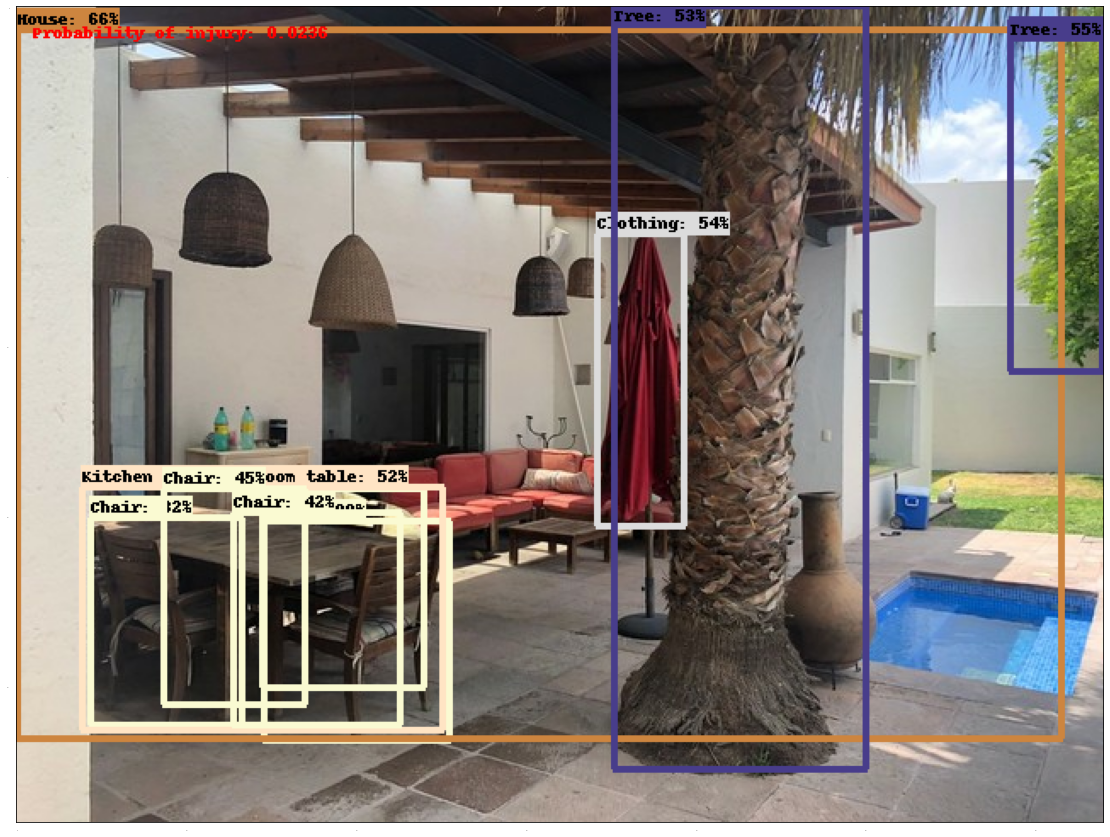

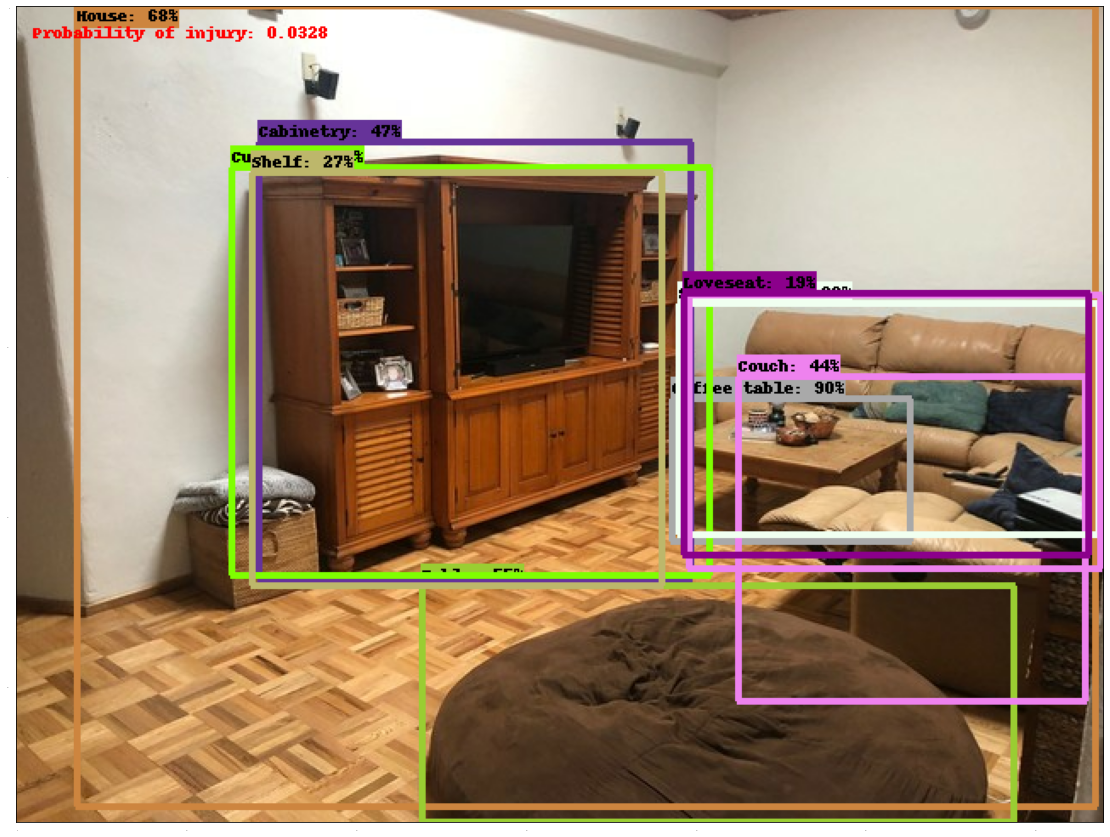

In [116]:
for i in range(5, 9):
  image_path = os.path.join(train_image_dir, 'test' + str(i) + '.jpeg')
  results, im, dims = detect_img(image_path)
  risk = calculate_risk(results, dims)

  disp = ImageDraw.Draw(im)
  disp.text((10, 10), "Probability of injury: " + str(round(risk, 4)), fill =(255, 0, 0))

  display_image(im)